In [40]:
from pixell import reproject, enmap, utils, enplot
import numpy as np
# define a plotting function
def eshow(x,**kwargs): enplot.show(enplot.plot(x,**kwargs))
import healpy as hp
import coop_post_processing as cpp
import coop_setup_funcs as csf
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import wcs as astwcs
import sys
# autoreload

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# read the ACT enmap to get its geometry
act_map = enmap.read_map("/mnt/raid-cita/mlokken/data/act_ymaps/ilc_SZ_yy.fits")
# downgrade 
act_map = act_map.downgrade(10)
shape, wcs = act_map.geometry
del act_map

In [62]:
# create a new enmap with the same geometry as the ACT map
new_map = enmap.zeros(shape,wcs)
# add a wide line of pixels to the new map
# dec_min, dec_max = -10*utils.degree, -5*utils.degree
# new_map[int(round(enmap.sky2pix(shape, wcs, [dec_min, 0])[0])):int(round(enmap.sky2pix(shape, wcs, [dec_max, 0])[0])), :] = 1

# add a diagonal line of pixels to the new map
diag_pixels = []
for i in range(shape[0]):
    for j in range(30):
        new_map[i, i+j] = 1
        diag_pixels.append([i, i+j])
        
    

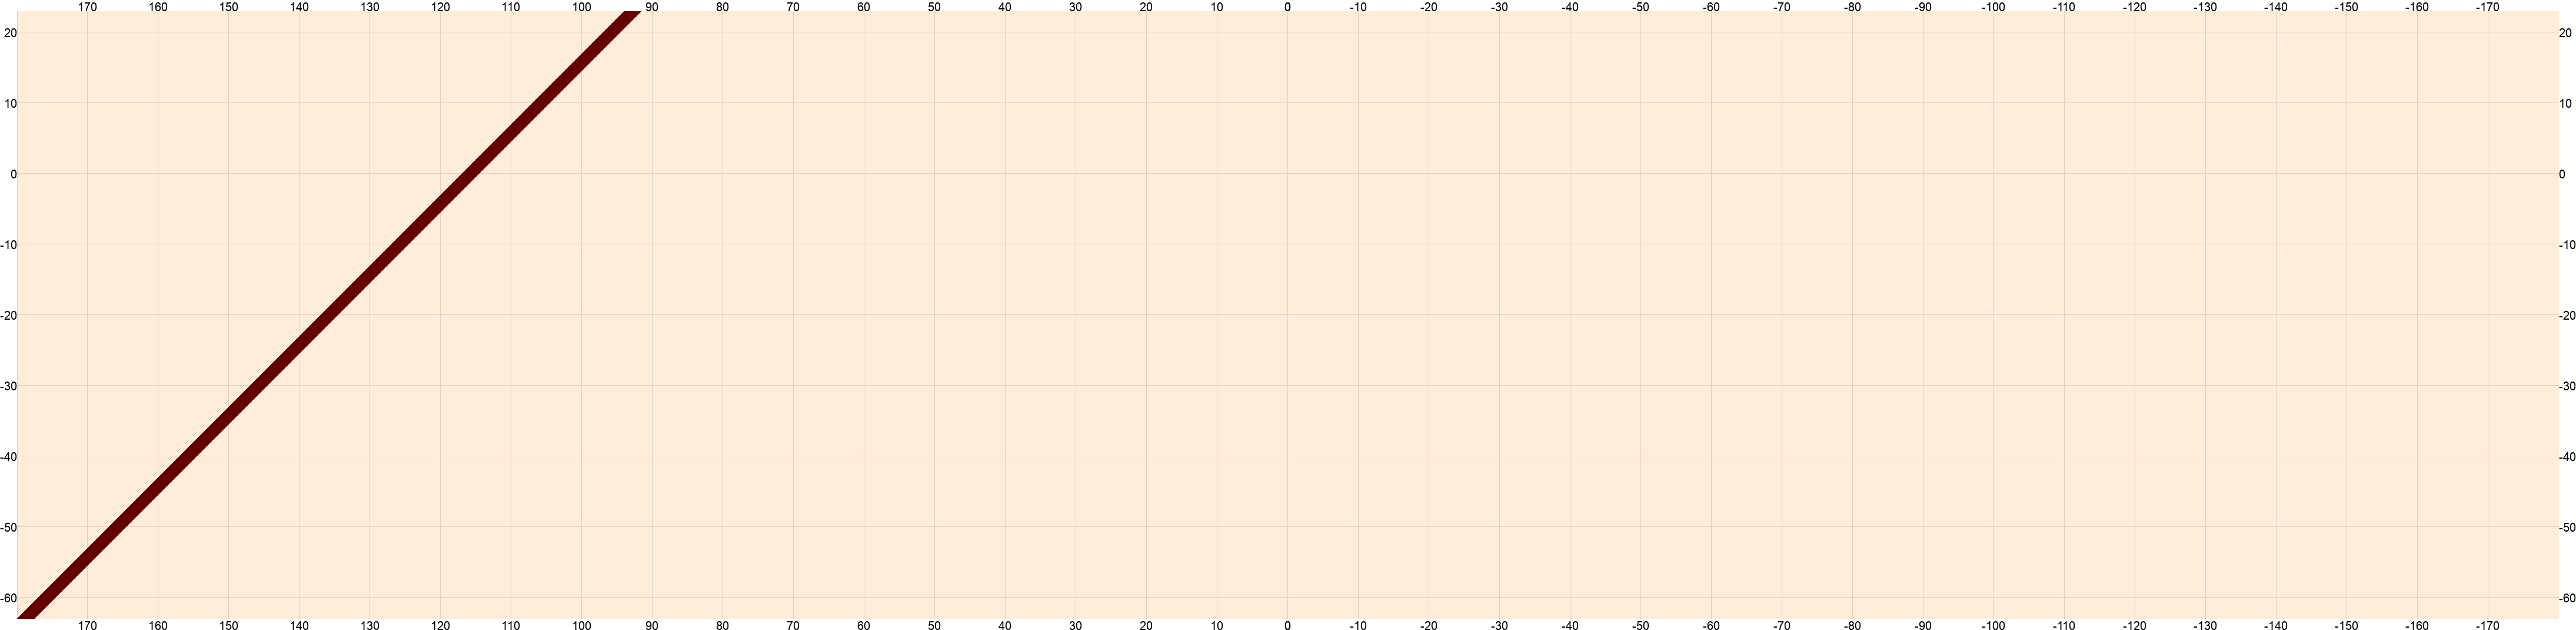

In [57]:
eshow(new_map, ticks=10)

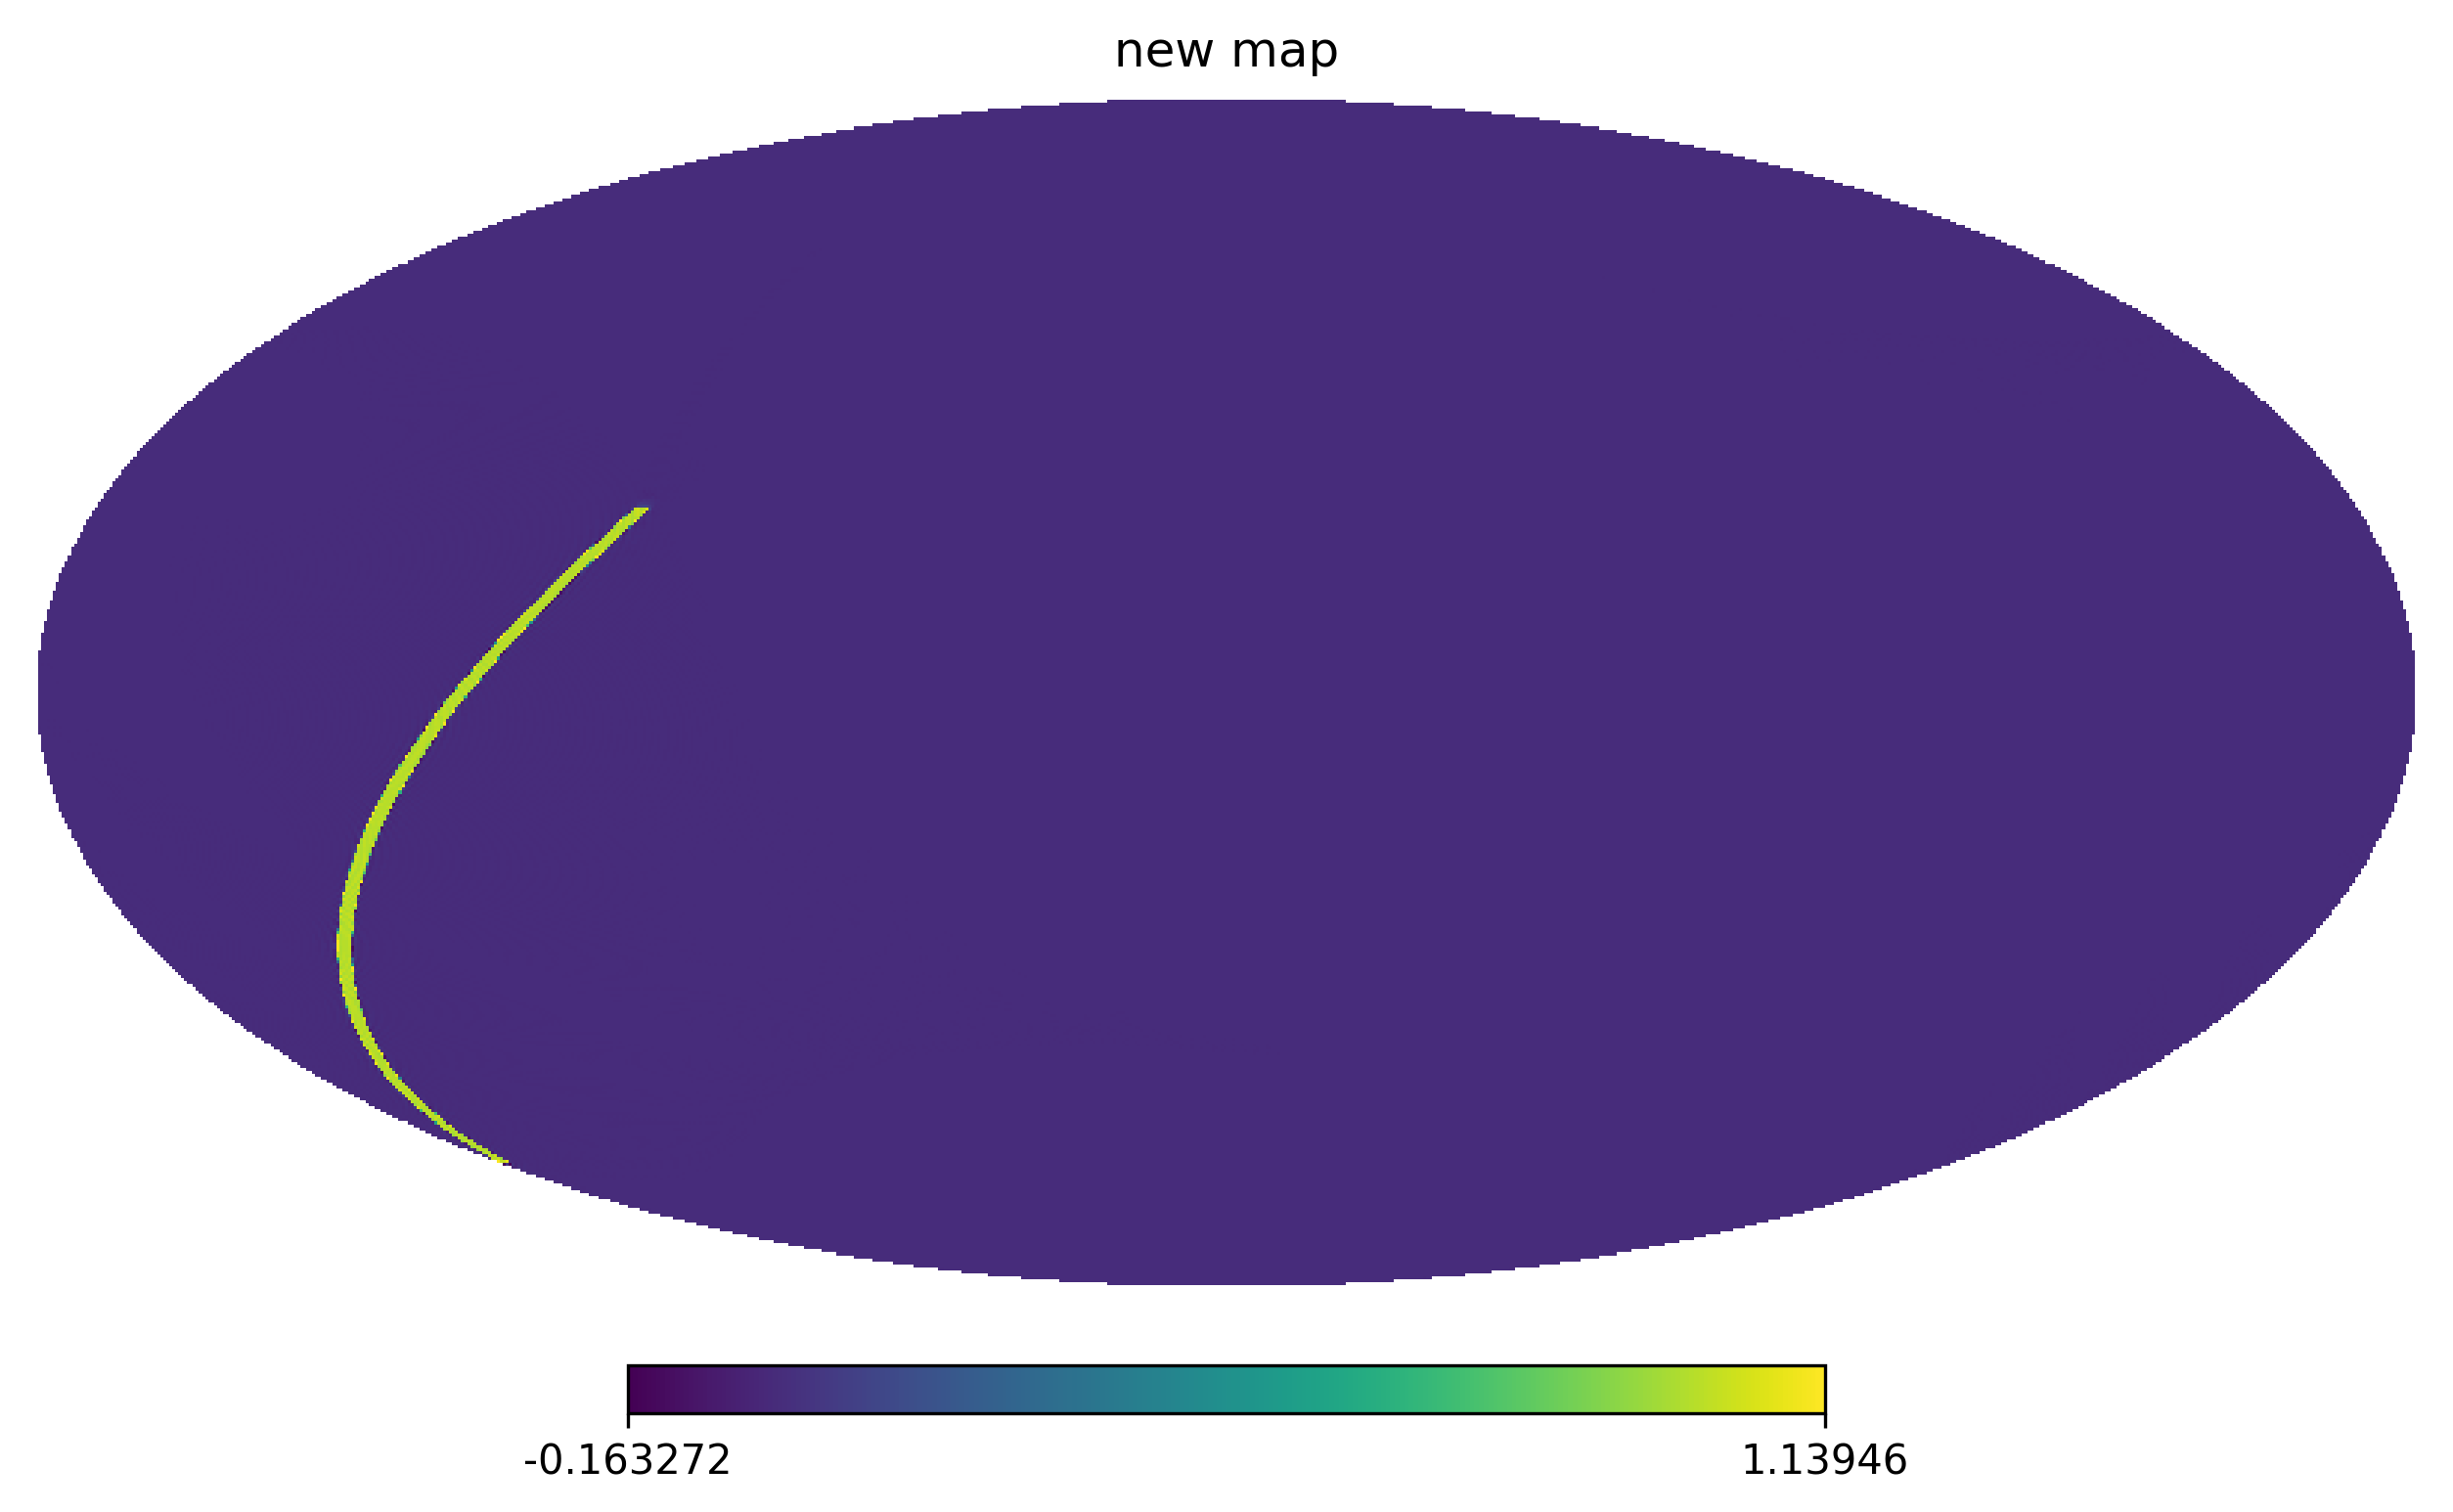

In [58]:
# transform new map to healpix
new_hmap = reproject.healpix_from_enmap(new_map, nside=2048, lmax=3000)

hp.mollview(new_hmap, title="new map")

In [61]:
# save new_map
hp.write_map("/mnt/raid-cita/mlokken/data/diagonal_line_map_hpx.fits", new_hmap, overwrite=True)
# save as enmap too
enmap.write_map("/mnt/raid-cita/mlokken/data/diagonal_line_map.fits", new_map)

In [99]:
# make some coordinates along the straight line
# ra = np.linspace(0, 360, 100)*utils.degree
# dec = np.full(ra.shape, (dec_min + dec_max)/2.)

# make some coordinates along the diagonal line
dec, ra = enmap.pix2sky(shape, wcs, np.array(diag_pixels).T)
ra = ra[::1000] # every 100th pixel]
dec = dec[::1000]

In [100]:
# Define a function to show on the map where the clusters are:
def mask_srcs(shape,wcs,srcs,radius_arcmin):
    """
    from orphics.maps by Mathew S. Madhavacheril
    Create a mask of circular holes in rectangular pixelization given
    a set of coordinates and a hole radius.

    Parameters
    ----------
    shape : tuple
        Shape of the output mask to be generated.
    wcs : `astropy.wcs.WCS`
        WCS object describing the output mask.
    srcs_deg : float `numpy.ndarray` of shape (2, Nobj)
        An array of Nobj coordinates in (Dec,RA) order and in degrees.
    radius_arcmin : float
        The radius of the circular hole to mask with zeros at each
        object location.

    Returns
    -------
    mask : `pixell.enmap.ndmap`
        A boolean pixell enmap with geometry (shape,wcs) and False
        inside the circular holes and True outside.

    """
    r = np.deg2rad(radius_arcmin/60.)
    return enmap.distance_from(shape,wcs,srcs, rmax=r) >= r
     

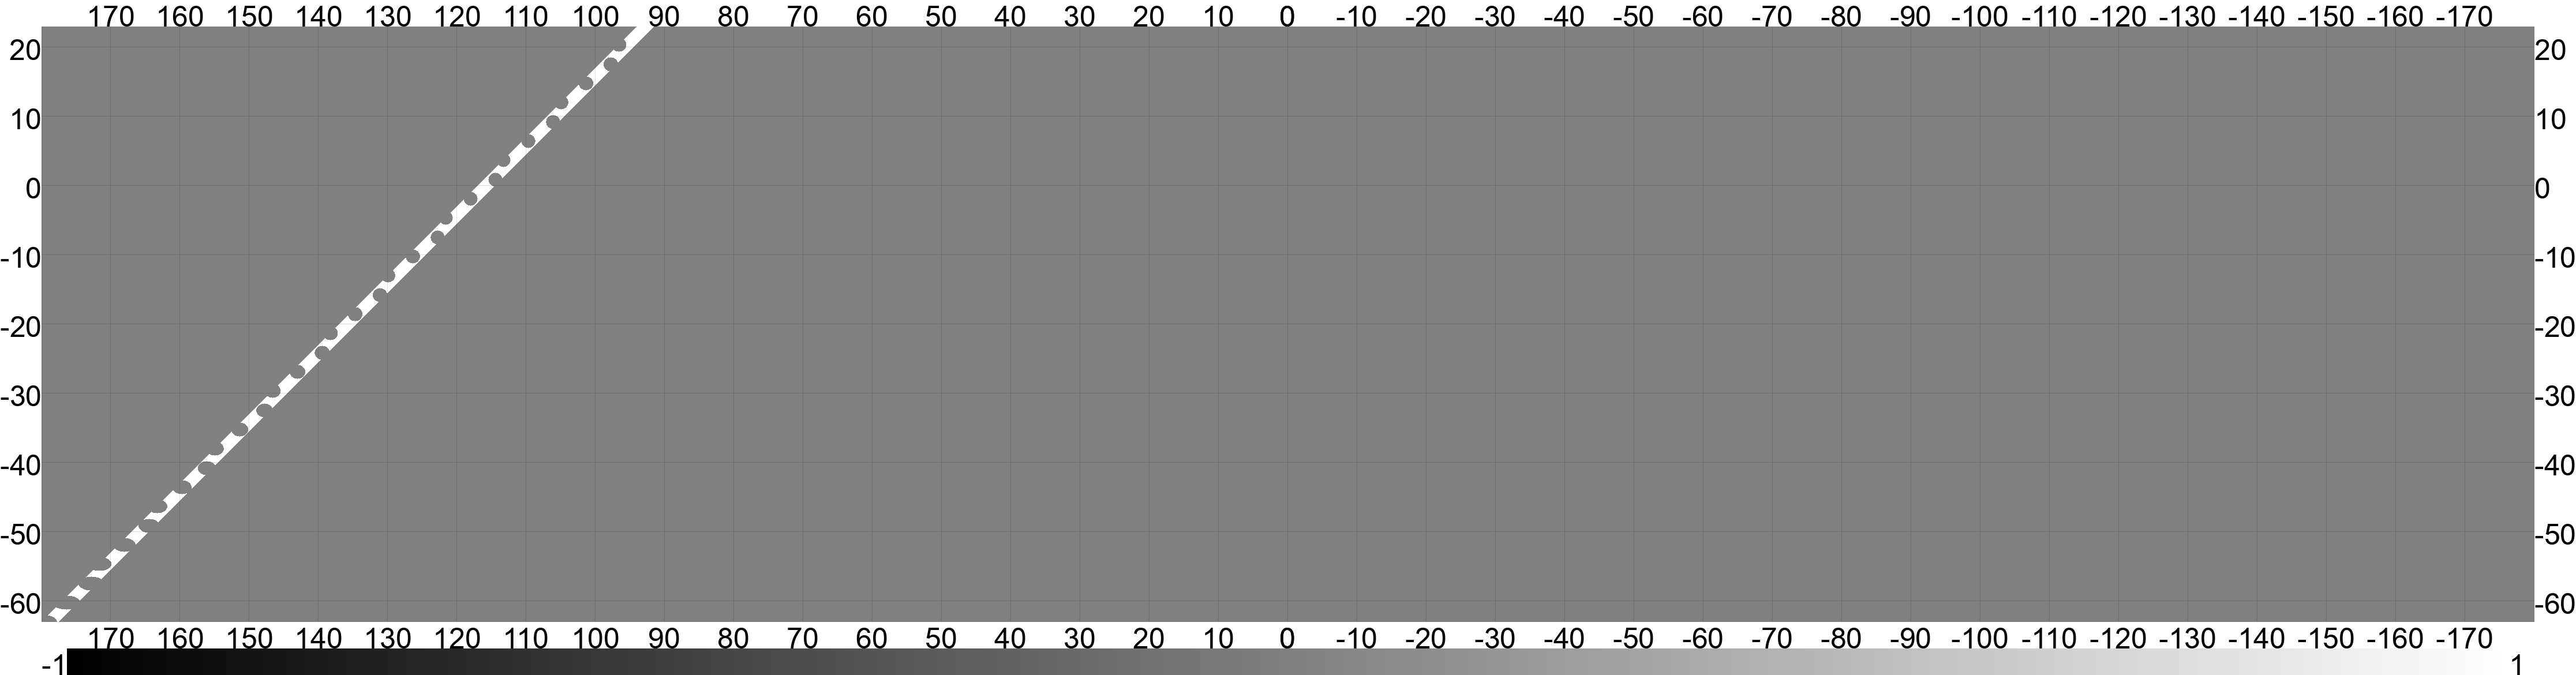

In [103]:
pt_visual = mask_srcs(shape,wcs,np.asarray((dec,ra)),60.)
eshow(pt_visual*new_map, ticks=10, colorbar=True, color='gray', font_size=50)

In [104]:
# save the points as both an (ra,dec) list and a (theta,phi) list
np.savetxt("ra_dec_list_diag.txt", np.asarray((np.rad2deg(ra),np.rad2deg(dec))).T)
healpix_theta = np.pi/2. - dec
healpix_phi = ra
np.savetxt("theta_phi_list_diag.txt", np.asarray((healpix_theta,healpix_phi)).T)

# Start here for analysis

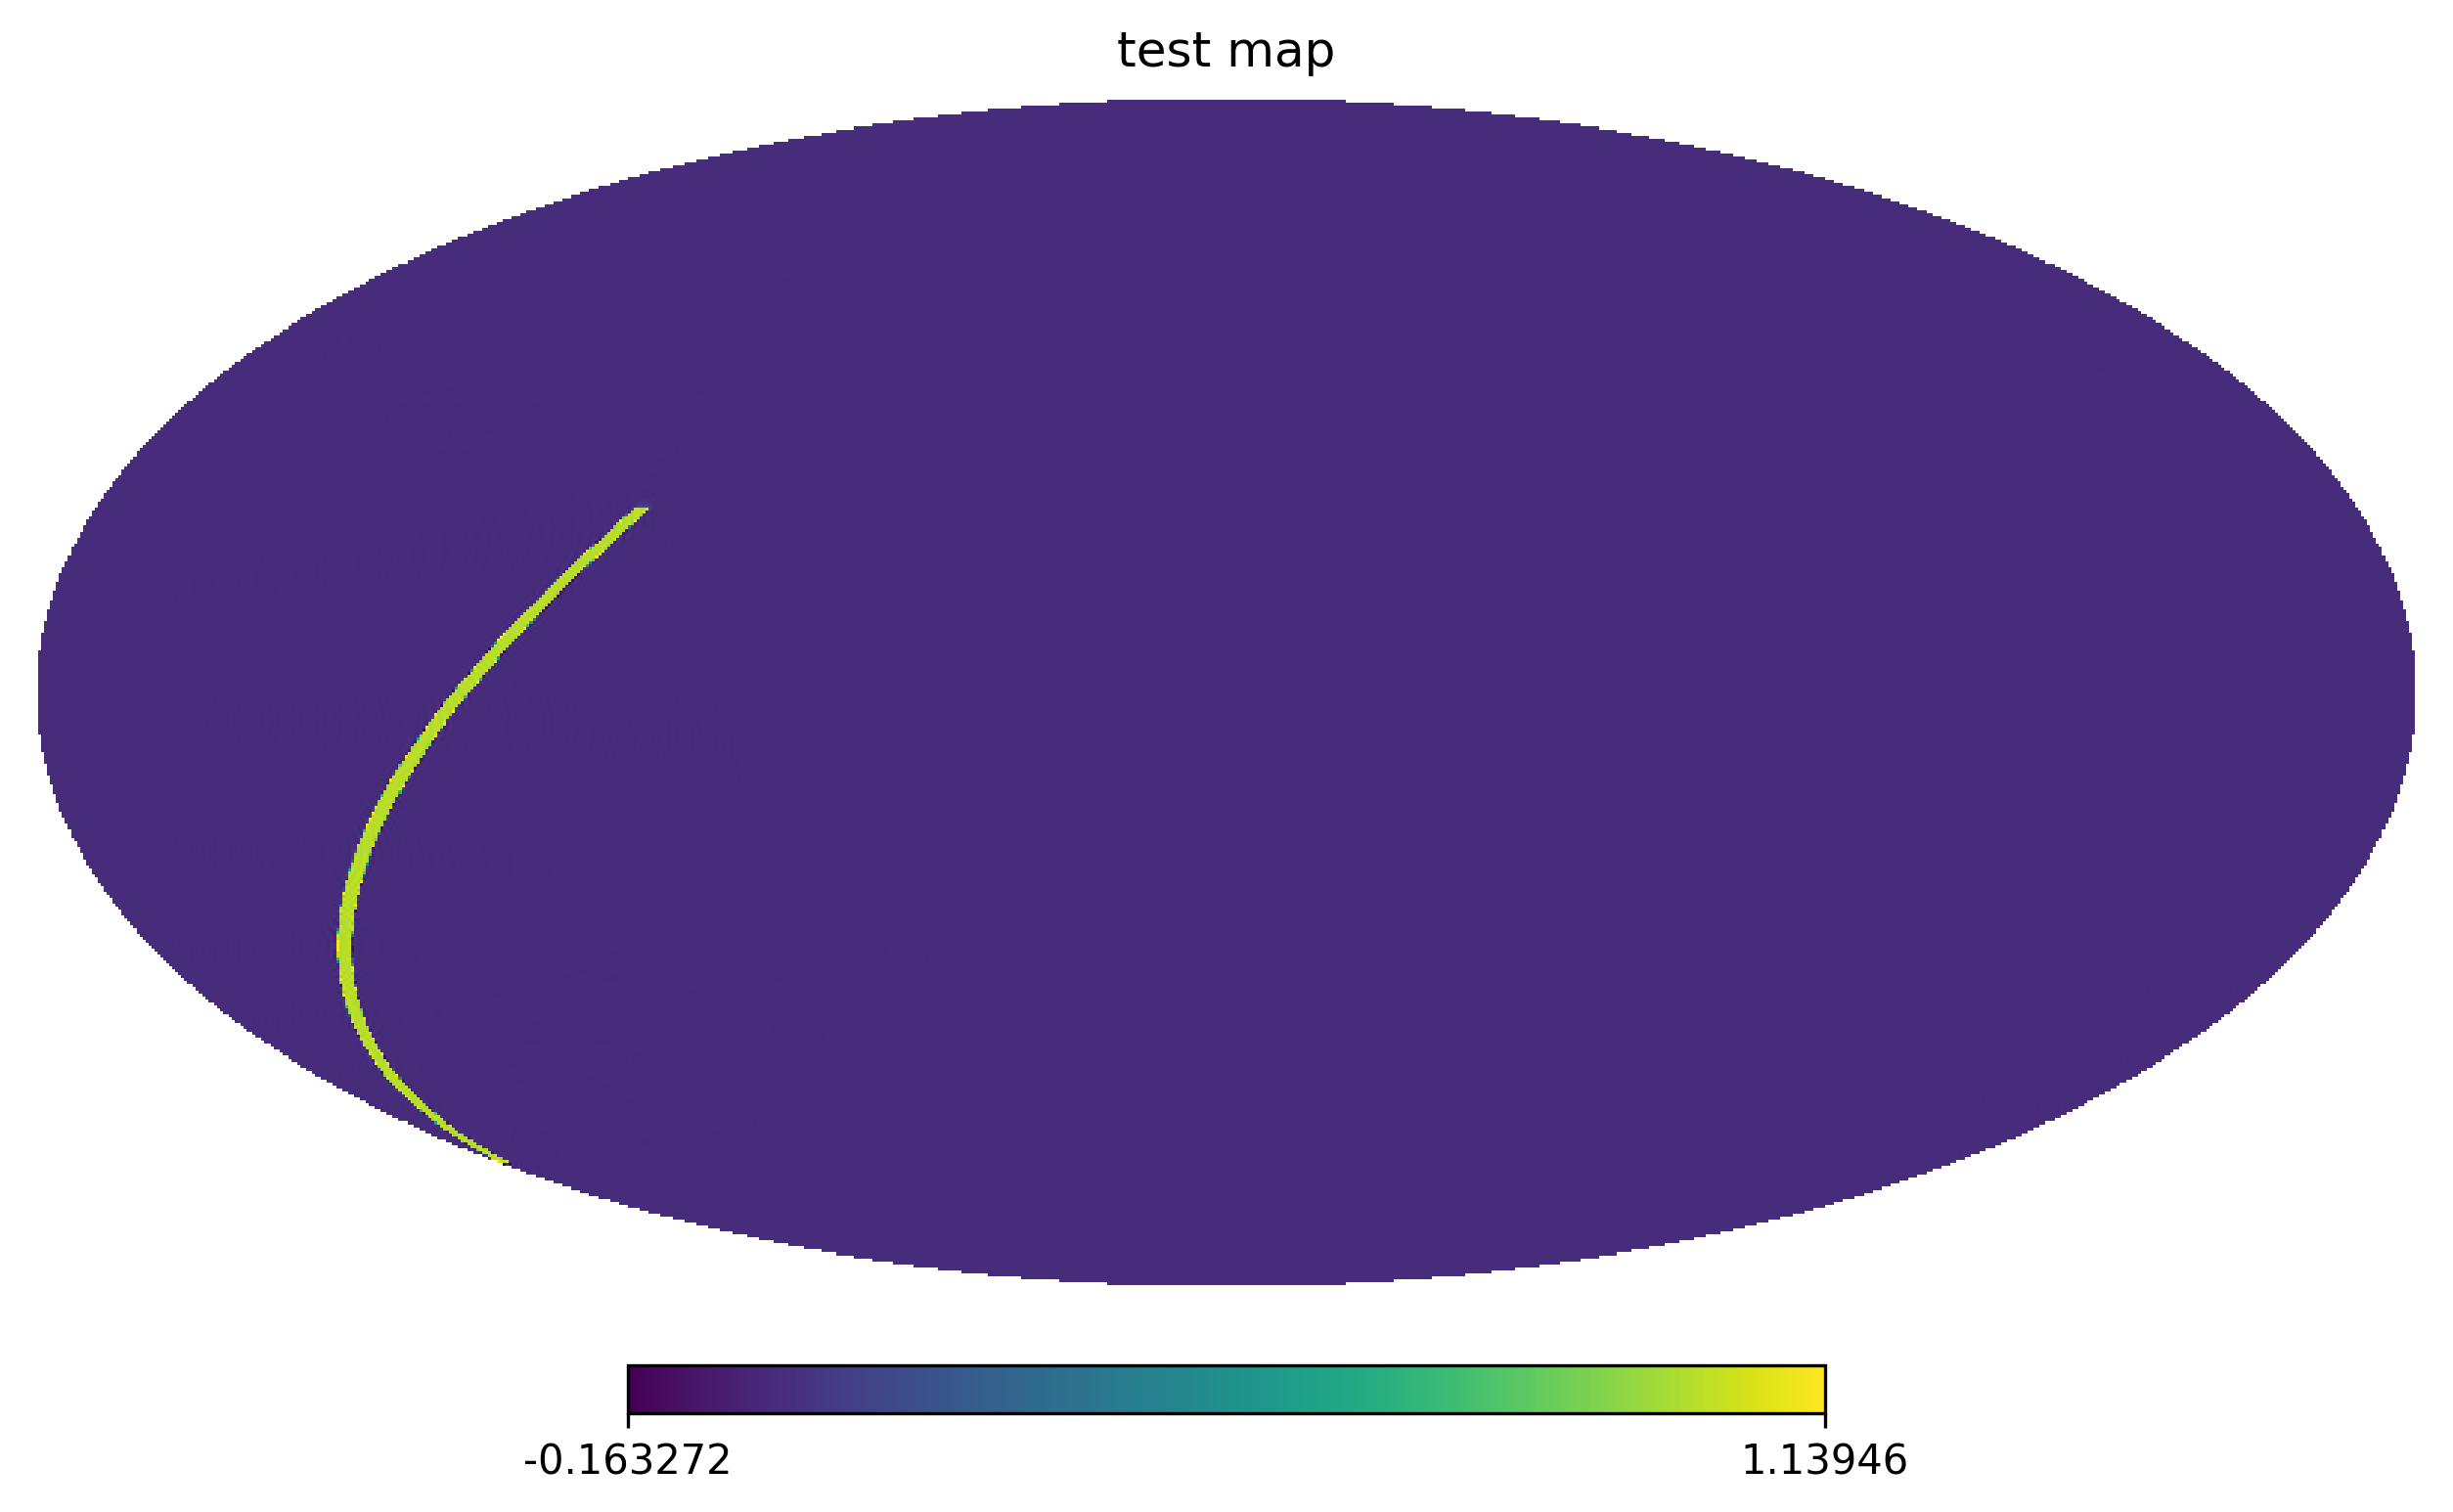

In [73]:
testmap_hpx = hp.read_map("/mnt/raid-cita/mlokken/data/diagonal_line_map_hpx.fits")
# testmap_hpx = hp.read_map("/mnt/raid-cita/mlokken/data/line_map_hpx.fits")
hp.mollview(testmap_hpx, title="test map")

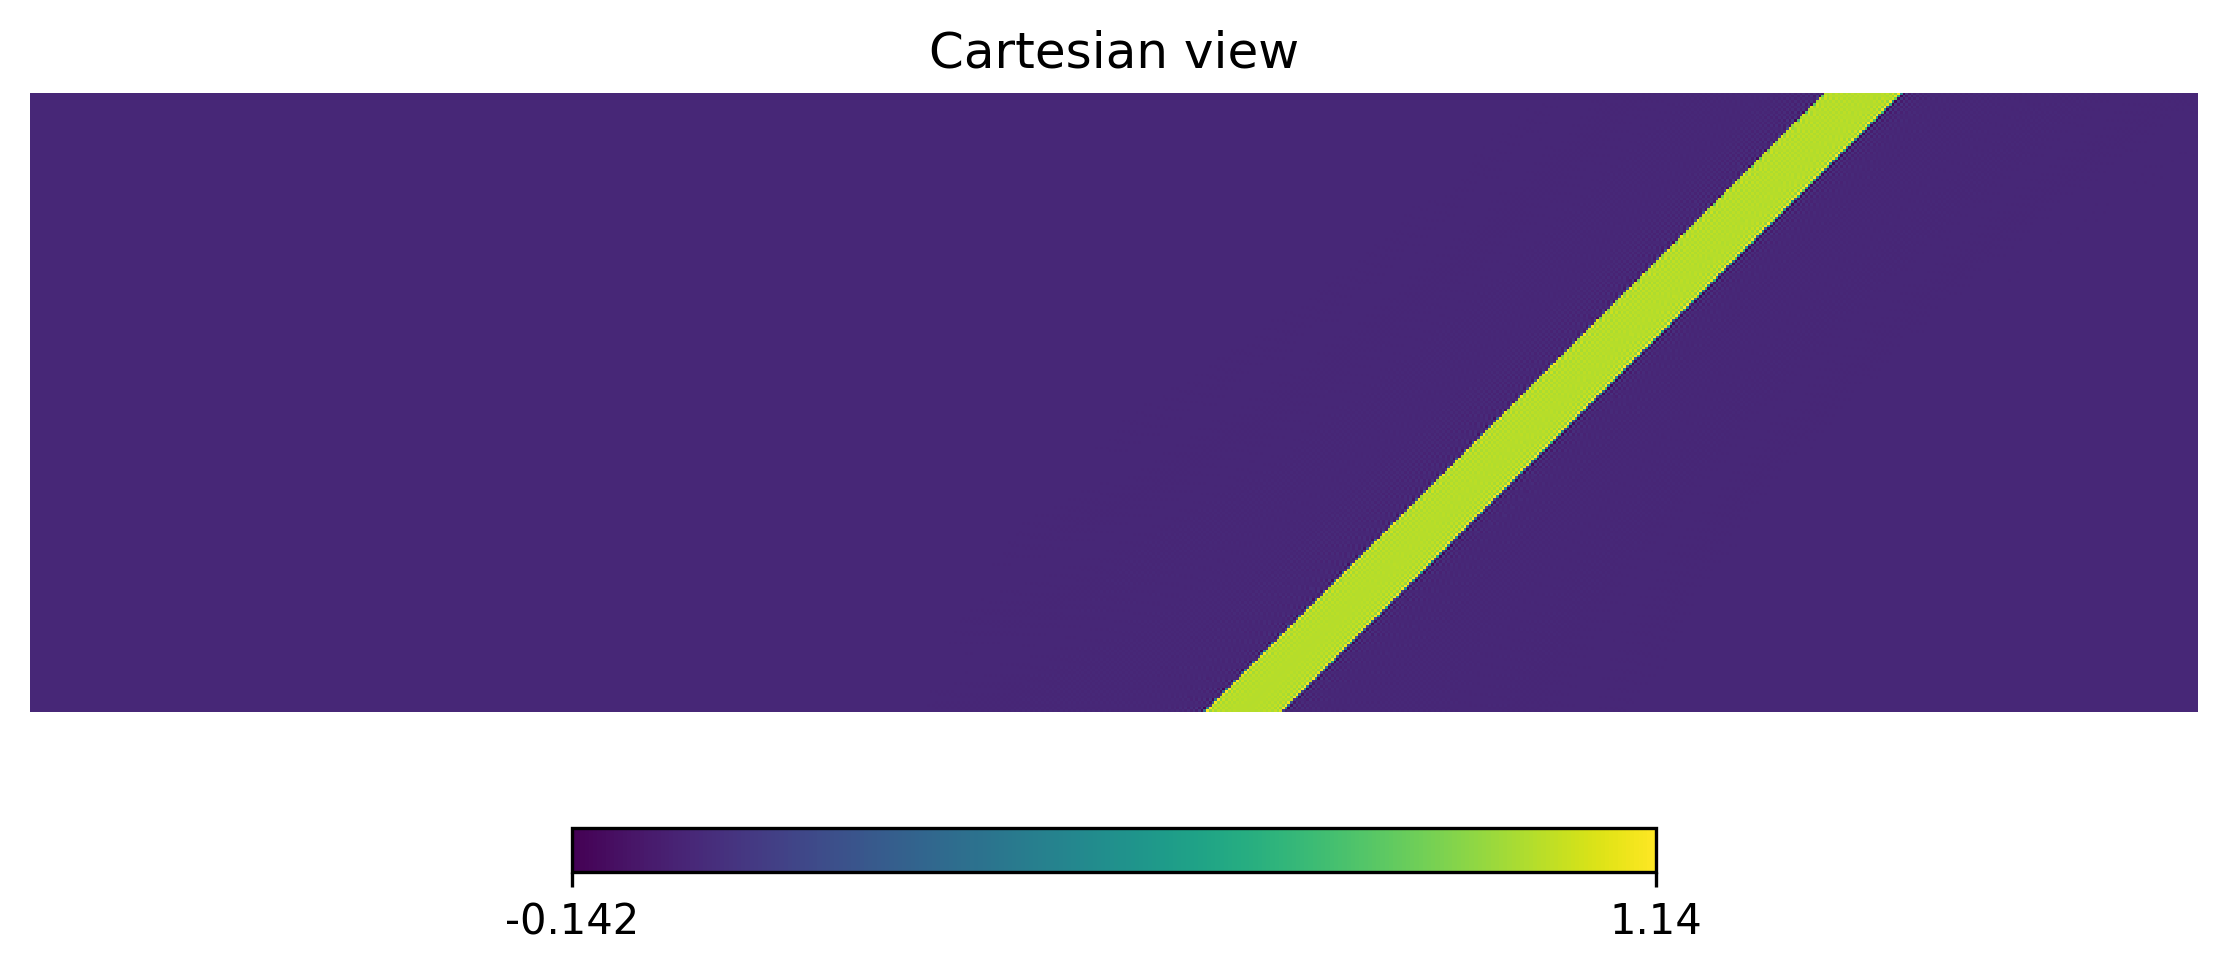

In [74]:
# read the orientation data
import coop_setup_funcs as csf
latmin = -15
latmax = 5
lonmin = 100
lonmax = 170
od_map_flat   = hp.cartview(testmap_hpx, lonra=[lonmin,lonmax], latra=[latmin,latmax], return_projected_map=True)

In [75]:
rot_angle,ra,dec, parityx, parityy, peakid = cpp.get_peakinfo("diag_line_map_pks_with_orientation.fits")
# rot_angle,ra,dec, parityx, parityy, peakid = cpp.get_peakinfo("line_map_pks_with_orientation.fits")

peaks_info = np.zeros((len(rot_angle), 5))
peaks_info[:,0] = rot_angle
peaks_info[:,1] = ra
peaks_info[:,2] = dec
peaks_info[:,3] = parityx
peaks_info[:,4] = parityy


FORMAT  =HEALPIX                                                                 [astropy.io.fits.card]
MAP     =/mnt/raid-cita/mlokken/data/diagonal_line_map_hpx.fits                  [astropy.io.fits.card]
FWHM    =0.                                                                      [astropy.io.fits.card]
OUTPUT  =/home/mlokken/oriented_stacking/oriented_superclustering/testing/diag_l [astropy.io.fits.card]
EXTERNAL=/home/mlokken/oriented_stacking/oriented_superclustering/testing/theta_ [astropy.io.fits.card]
NU_MIN  =-1.e30                                                                  [astropy.io.fits.card]
NU_MAX  =1.e30                                                                   [astropy.io.fits.card]
FWHM_NU =0.                                                                      [astropy.io.fits.card]
E_MIN   =0                                                                       [astropy.io.fits.card]
E_MAX   =1.e30                                                  

In [76]:
w = astwcs.WCS(naxis=2)

height = float(od_map_flat.shape[0])
length = float(od_map_flat.shape[1])
cdeltaX, crvalX = (lonmin-lonmax)/length, (lonmin+lonmax)/2.
cdeltaY, crvalY = (latmax-latmin)/height, (latmin+latmax)/2.


w.wcs.crpix = length/2., height/2.
print(w.wcs.crpix)
w.wcs.crval = [crvalX,crvalY]
print(w.wcs.crval)
w.wcs.cdelt = np.array([cdeltaX,cdeltaY])
print(w.wcs.cdelt)
w.wcs.ctype = ["RA", "DEC"]

[400.  114.5]
[135.  -5.]
[-0.0875      0.08733624]


In [77]:
sel_area  = (peaks_info[:,1]>lonmin)&(peaks_info[:,1]<lonmax)&(peaks_info[:,2]>latmin)&(peaks_info[:,2]<latmax)
selection = sel_area
Xpix,Ypix = w.all_world2pix(peaks_info[:,1][selection],peaks_info[:,2][selection],0)
U_arr, V_arr = cpp.get_vector_components(peaks_info[:,0][selection])

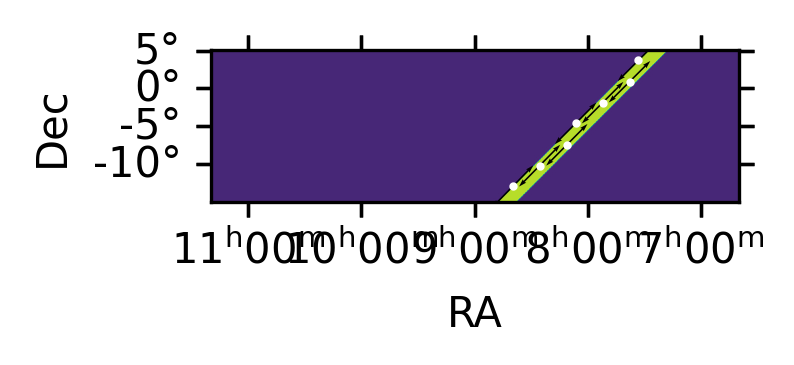

In [78]:
# Make the figure

fig = plt.figure(figsize=(5,3))

mpl.rcParams['figure.dpi'] = 300

nrows = 2
ax1 = plt.subplot(1, 2, 1, projection=w)
# ax2 = plt.subplot(1, 2, 2, projection=w)

ax1.set_xticks([])
ax1.set_xticklabels([])

dmap = ax1.imshow(od_map_flat)

mpl.rcParams['contour.negative_linestyle'] = 'solid'

ax1.set_xlabel("RA")
ax1.set_ylabel("Dec")


# Make the figure



ax1.quiver(Xpix,Ypix, -U_arr, V_arr, width=0.003, color = 'k',  zorder=2)
qv = ax1.quiver(Xpix,Ypix, U_arr, -V_arr, width=0.003, color = 'k',  zorder=3)
ax1.scatter(Xpix,Ypix, linewidths=1, s=1, c='w', zorder=4)

lon = ax1.coords[0]
lat = ax1.coords[1]

In [79]:
# define the enmap
testmap = enmap.read_map("/mnt/raid-cita/mlokken/data/diagonal_line_map.fits")
# testmap = enmap.read_map("/mnt/raid-cita/mlokken/data/line_map.fits")

In [80]:
# stack the map
# flat line map
# instert path
sys.path.append("..")
import stacking_functions as sf

# make a Chunk object
Chunk = sf.Chunk(len(ra), ra, dec, rot_angle)



In [81]:
cutout_size_deg = 10
cutout_resolution_deg = 0.5
orient = 'symmetric'
stack = sf.stackChunk(Chunk, testmap, cutout_size_deg, cutout_resolution_deg, orient)


x_lrg shape is (43,) y_lrg shape is (43,) thumbnail shape is (43, 43)
- analyze object 0


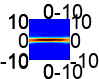

0.17453292519943295 6.0999257357201815 -0.17453292519943295 0.1832595714594046


In [82]:
eshow(stack, ticks=10)
# get min, max ra, dec from stack
ra_min = enmap.pix2sky(stack.shape, stack.wcs, [0,0])[1]
ra_max = enmap.pix2sky(stack.shape, stack.wcs, [0,stack.shape[1]])[1]
dec_min = enmap.pix2sky(stack.shape, stack.wcs, [0,0])[0]
dec_max = enmap.pix2sky(stack.shape, stack.wcs, [stack.shape[0],0])[0]
print(ra_min, ra_max, dec_min, dec_max)


Text(0, 0.5, 'Y [deg]')

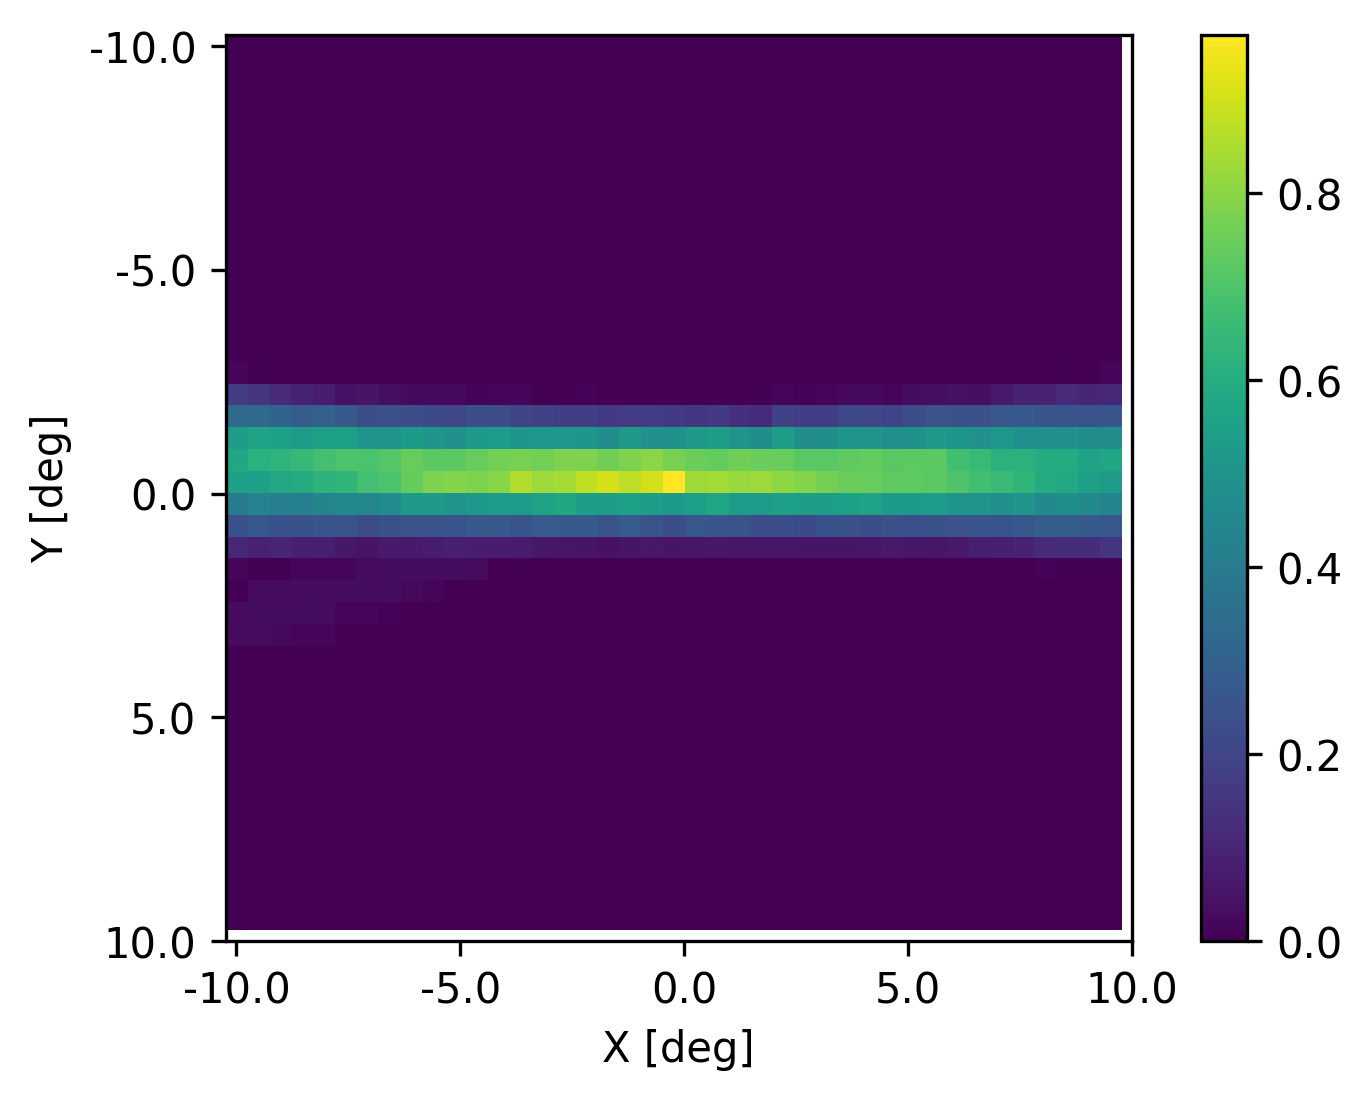

In [83]:
plt.imshow(stack/ Chunk.nObj)
plt.colorbar()
# replace the tick labels with ones going from -(cutout_size_deg) to (cutout_size_deg)
xticks = np.linspace(0, stack.shape[1], 5)
yticks = np.linspace(0, stack.shape[0], 5)
xticklabels = np.round(np.linspace(-cutout_size_deg, cutout_size_deg, 5),2)
yticklabels = np.round(np.linspace(-cutout_size_deg, cutout_size_deg, 5),2)
plt.xticks(xticks, xticklabels)
plt.yticks(yticks, yticklabels)
plt.xlabel("X [deg]")
plt.ylabel("Y [deg]")
